In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from beeid2.models import simple_cnnv2, ContrastiveLearning
from beeid2.data_utils import filename2image
from beeid2.evaluation import mAP_evaluation, mAP_track_model_evaluation, cmc_track_model_evaluation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from tqdm import tqdm
import glob
from skimage import io
from beeid2.evaluation import get_query_galleries, plot_query_gallery, get_query_galleries_tracks
from collections import defaultdict

def to_np_array(values, dim=128):
    return np.concatenate(list(values)).reshape(-1, dim)


EVALUATION_FILES = {
    "test": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_unnormalized.csv",
    "valid_with_shared_ids_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/valid_with_shared_ids_unnormalized.csv",
    "valid_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/valid_galleries_unnormalized.csv",
    "test_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_galleries_unnormalized.csv",
    "test_no_train_overlap_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_no_train_overlap_unnormalized.csv",
    "test_same_hour_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_same_hour2_unnormalized.csv",
    "test_same_hour_diff_day_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_different_day_same_hour2_unnormalized.csv",
    "test_diff_day_cmc": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_different_day2_unnormalized.csv",
    "track_test_same_hour": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_same_hour3_unnormalized.csv",
    "track_test_same_hour_diff_day": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_different_day_same_hour3_unnormalized.csv",
    "track_test_diff_day": "/home/jchan/beeid/notebooks/cmc_experiments/data/test_different_day3_unnormalized.csv",

}



In [3]:
MODEL = "../../models2/2111240952_tagged_augmentataion_untagged_augmentataion_simplecnnv2_convb3_dim_128/model.tf/"

In [4]:
base_model = load_model(MODEL)

In [5]:
queryG = get_query_galleries(base_model)

13/13 [==============================] - 1s 84ms/step


100%|██████████| 654/654 [00:02<00:00, 250.12it/s]


In [6]:
APs = defaultdict(list)
topN = defaultdict(list)
N=1
for qg in queryG:
    
    query, gallery = qg
    query = query.iloc[0]
    query_id = query.track_tag_id
    query = np.expand_dims(query.emb, axis=0)

    labels = gallery.track_tag_id.values
    distances = tf.matmul(query, to_np_array(gallery["emb"].values).T)
    distances = np.squeeze(distances.numpy())
    
    # mAP
    binary_labels = (labels == query_id).astype(bool)
    precision, recall, thresholds = precision_recall_curve(binary_labels, distances)
    AP = auc(recall, precision)
    APs[query_id].append(AP)
    
    # Top N accuracy 
    min_idx = np.argsort(distances)
    predicted_ids = labels[min_idx[-N:]]
    acc = np.any(predicted_ids == query_id)
    topN[query_id].append(acc)

metrics = dict()
metrics["id"] = list()
metrics["mAP"] = list()
metrics["n"] = list()
metrics["top1"] = list()
for tag_id in APs:
    metrics["id"].append(tag_id)
    metrics["mAP"].append(np.mean(APs[tag_id]))
    metrics["n"].append(len(APs[tag_id]))
    metrics["top1"].append(np.mean(topN[tag_id]))

In [36]:
sorted_mAP_indx = np.argsort(metrics["mAP"])[::-1]
#sorted_topN_indx = np.argsort(metrics["top1"])[::-1]

ids = np.array(metrics["id"])[sorted_mAP_indx]
#ids = np.array(metrics["id"])[sorted_topN_indx]

test_df = pd.read_csv(EVALUATION_FILES["test"])
test_df = test_df[test_df.track_tag_id.isin(ids)]
test_df["datetime2"] = pd.to_datetime(test_df["datetime"])

tag_examples = test_df.groupby('tag_id').sample(1)

filenames = tag_examples.filename.values
tag_ids =  tag_examples.tag_id.values.astype(int)
images = filename2image(filenames)
tag_image_dict = dict()
for tid, image in zip(tag_ids, images):
    tag_image_dict[tid] = image
    
sorted_images = list()
for tid in ids:
    sorted_images.append(tag_image_dict[tid])

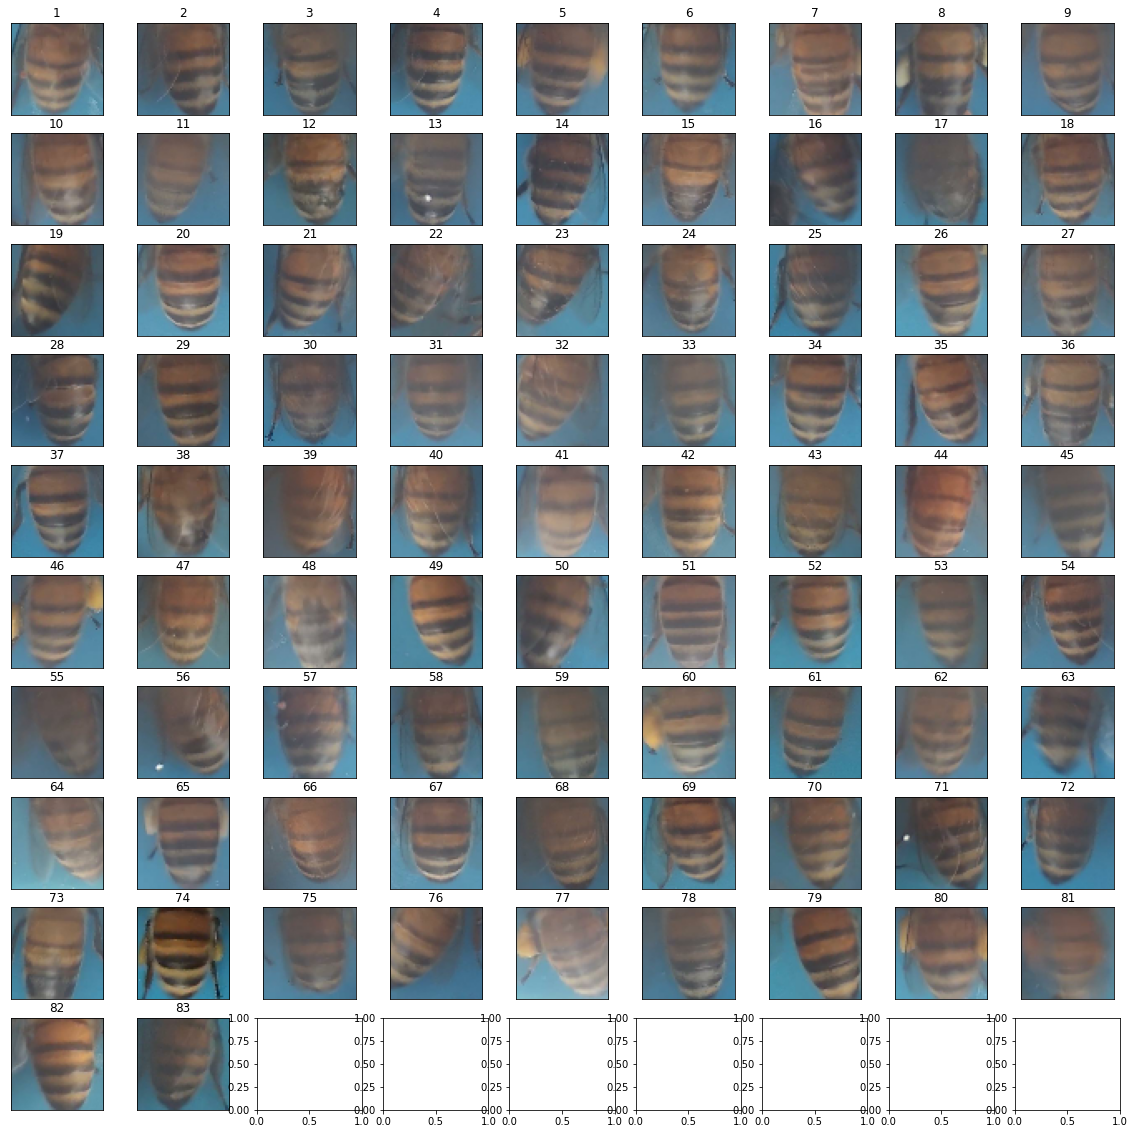

In [37]:
fig, ax = plt.subplots(10, 9, figsize=(20, 20))
ax = ax.ravel()

for i in range(len(sorted_images)):
    ax[i].imshow(sorted_images[i])
    ax[i].set_title("{}".format(i+1))
    ax[i].set_xticks([])
    ax[i].set_yticks([])


In [15]:
# sorted_mAP_indx = np.argsort(metrics["mAP"])[::-1]
sorted_topN_indx = np.argsort(metrics["top1"])[::-1]

# ids = np.array(metrics["id"])[sorted_mAP_indx]
ids = np.array(metrics["id"])[sorted_topN_indx]

test_df = pd.read_csv(EVALUATION_FILES["test"])
test_df = test_df[test_df.track_tag_id.isin(ids)]
test_df["datetime2"] = pd.to_datetime(test_df["datetime"])

tag_examples = test_df.groupby("global_track_id").sample(1)

filenames = tag_examples.filename.values
tag_ids =  tag_examples.tag_id.values.astype(int)
images = filename2image(filenames)
tag_image_dict = defaultdict(list)
for tid, image in zip(tag_ids, images):
    tag_image_dict[tid].append(image)
    
sorted_images = list()
for tid in ids:
    sorted_images.append(tag_image_dict[tid])

In [ ]:
NIDS=20
EXAMPLES_LIMIT=10
fig, ax = plt.subplots(NIDS, EXAMPLES_LIMIT, figsize=(20, 40))
# ax = ax.ravel()

for j in range(NIDS):
    for i in range(EXAMPLES_LIMIT):
        
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        if i >= len(sorted_images[j]):
            continue
        ax[j, i].imshow(sorted_images[j][i])
        ax[j, i].set_title("{}".format(j))
        
plt.savefig("examples_by_similarity.png")